In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from scipy.stats import sem, t
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from scipy.stats import sem, t
import seaborn as sns
import numpy as np
#from Bio.SeqUtils.ProtParam import ProtParam
from sklearn.utils import resample
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mannwhitneyu
import re
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParam
from scipy.stats import linregress


In [2]:
#INPUT
BRCA1_ddg_results_df = pd.read_csv("BRCA1_data_function_ddg.csv")
BRCA2_ddg_results_df = pd.read_csv("BRCA2_data_function_ddg.csv")
PALB2_ddg_results_df = pd.read_csv("PALB2_data_function_ddg.csv")
RAD51C_ddg_results_df = pd.read_csv("RAD51C_data_function_ddg.csv")



BRCA1_4OFB_features_df = pd.read_csv("BRCA1_4OFB_plddt_distance.csv", sep='\t')
BRCA1_7LYB_features_df = pd.read_csv("BRCA1_7LYB_plddt_distance.csv", sep='\t')
BRCA1_1JNX_features_df = pd.read_csv("BRCA1_1JNX_plddt_distance.csv", sep='\t')
BRCA2_1MJE_features_df = pd.read_csv("BRCA2_1MJE_plddt_distance.csv", sep='\t')
PALB2_3EU7_features_df = pd.read_csv("PALB2_3EU7_plddt_distance.csv", sep='\t')
RAD51C_8FAZ_features_df = pd.read_csv("RAD51C_8FAZ_plddt_distance.csv", sep='\t')
PALB2_2W18_features_df = pd.read_csv("PALB2_2W18_plddt_distance.csv", sep='\t')

In [3]:
def compute_ci(df, num_bootstraps, ci_level):
    corr_bootstraps = []
    num_cols = df.shape[1]
    
    for _ in range(num_bootstraps):
        df_boot = df.apply(lambda x: resample(x, replace=True, random_state=_))
        if num_cols > 1:
            corr_boot = df_boot.corr().values.flatten()
        else:
            corr_boot = np.array([1.0])
        corr_bootstraps.append(corr_boot)

    corr_bootstraps = np.array(corr_bootstraps)
    ci_lower = np.percentile(corr_bootstraps, (1 - ci_level) / 2 * 100, axis=0)
    ci_upper = np.percentile(corr_bootstraps, (1 + ci_level) / 2 * 100, axis=0)

    return ci_lower, ci_upper

aro_aa = ['F', "Y", "W", "H"]
def extract_integers(s):
    return [int(match.group()) for match in re.finditer(r'\d+', s)]

def spearmanr_ci(x, y, alpha=0.05):
    r, p = stats.spearmanr(x, y)
    n = len(x)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))
    err = (hi - p) + (p - lo)
    return r, p, lo, hi,n, err


def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value
    lo = z - z_crit * se
    hi = z + z_crit * se
    return (z_to_r(lo), z_to_r(hi))

def pearsonr_ci_boot(x, y, ci=95, n_boots=1000):
    x = np.asarray(x)
    y = np.asarray(y)
    rand_ixs = np.random.randint(0, x.shape[0], size=(n_boots, x.shape[0]))
    x_boots = x[rand_ixs]
    y_boots = y[rand_ixs]
    x_mdiffs = x_boots - x_boots.mean(axis=1)[:, None]
    y_mdiffs = y_boots - y_boots.mean(axis=1)[:, None]

    x_ss = np.einsum('ij, ij -> i', x_mdiffs, x_mdiffs)
    y_ss = np.einsum('ij, ij -> i', y_mdiffs, y_mdiffs)

    r_boots = np.einsum('ij, ij -> i', x_mdiffs, y_mdiffs) / np.sqrt(x_ss * y_ss)

    ci_low = np.percentile(r_boots, (100 - ci) / 2)
    ci_high = np.percentile(r_boots, (ci + 100) / 2)
    return ci_low, ci_high

def compute_r2_p(df, col1, col2):
    data = df[[col1, col2]].dropna()
    total = len(data)
    slope, intercept, r_value, p_value, std_err = linregress(data[col1], data[col2])
    r_squared = r_value ** 2
    t_value = t.ppf(0.975, df=len(data) - 2)  
    slope_ci = (slope - t_value * std_err, slope + t_value * std_err)
    intercept_ci = (intercept - t_value * std_err, intercept + t_value * std_err)
    return r_squared, r_value, p_value, total, slope, intercept, slope_ci

def plot_sig_boxplot(df, data_call, functional_column, predictor, title):
    df = df[df['predictor'] == predictor]
    group_0 = df[df[functional_column] == 'Normal'][data_call]
    group_1 = df[df[functional_column] == 'Abnormal'][data_call]
    statistic, p_value = mannwhitneyu(group_0, group_1)

    ax = plt.gca()
    sns.boxplot(x=functional_column, y=data_call, data=df, ax=ax)
    ax.set_xlabel('Functional Classification', fontsize=12)  
    ax.set_ylabel(title, fontsize=12) 
    ax.set_title(f'{predictor} ΔΔG in {title}', fontsize=14)  
    if p_value < 0.05:
        significant_combinations = [((0.25, 0.75), p_value)]
        y_range = max(max(group_0), max(group_1)) - min(min(group_0), min(group_1))
        top = max(max(group_0), max(group_1))
        for i, significant_combination in enumerate(significant_combinations):
            x1 = significant_combination[0][0] - 0.1 
            x2 = significant_combination[0][1] + 0.1  
            level = len(significant_combinations) - i
            bar_height = (y_range * 0.07 * level) + top
            bar_tips = bar_height - (y_range * 0.02)
            ax.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')

            p = significant_combination[1]
            if p < 0.001:
                sig_symbol = '***'
            elif p < 0.01:
                sig_symbol = '**'
            elif p < 0.05:
                sig_symbol = '*'
            text_height = bar_height + (y_range * 0.01)
            ax.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
            
def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count)
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1
    return aucs[0], delongcov

def delong_pr_auc_variance(y_true, y_pred):
    order, label_1_count = compute_ground_truth_statistics(y_true)
    predictions_sorted_transposed = np.vstack((y_pred, y_pred))[:, order]
    pr_aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    #pr_aucs = average_precision_score
    return pr_aucs[0], delongcov

def compute_auc_ci(y_true, y_pred, n_bootstrap=1000, alpha=0.95):
    auc, auc_cov = delong_roc_variance(y_true, y_pred)
    auc_std = np.sqrt(auc_cov)
    auc_samples = []
    for _ in range(n_bootstrap):
        y_true_boot, y_pred_boot = resample(y_true, y_pred)
        auc_boot = average_precision_score(y_true_boot, y_pred_boot)
        auc_samples.append(auc_boot)
    lower_quantile = (1 - alpha) / 2.0 * 100
    upper_quantile = (alpha + (1 - alpha) / 2.0) * 100
    ci = np.percentile(auc_samples, [lower_quantile, upper_quantile])
    
    return auc, auc_std, ci


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

def calculate_molecular_weight(aa):
    protein = ProteinAnalysis(aa) 
    molecular_weight = protein.molecular_weight()
    return molecular_weight

def calculate_aromaticity(aa):
    protein = ProteinAnalysis(aa) 
    aromaticity = protein.aromaticity()
    return aromaticity


def calculate_instability_index(aa):
    protein = ProteinAnalysis(aa) 
    instability_index = protein.instability_index()
    return instability_index

def calculate_flexibility(aa):
    protein = ProteinAnalysis(aa) 
    flexibility = protein.flexibility()
    return flexibility

def calculate_isoelectric_point(aa):
    protein = ProteinAnalysis(aa) 
    isoelectric_point = protein.isoelectric_point()
    return isoelectric_point

def calculate_gravy(aa):
    protein = ProteinAnalysis(aa) 
    gravy = protein.gravy()
    return gravy

def generate_properties(df):
    df['AA_weight'] = df['Amino_acid'].apply(lambda x: calculate_molecular_weight(x))
    df['aromaticity'] = df['Amino_acid'].apply(lambda x: calculate_aromaticity(x))
#BRCA1_1JNX_features_df['flexibility'] = BRCA1_1JNX_features_df['Amino_acid'].apply(lambda x: calculate_flexibility(x))
    df['isoelectric_point'] = df['Amino_acid'].apply(lambda x: calculate_isoelectric_point(x))
    df['gravy'] = df['Amino_acid'].apply(lambda x: calculate_gravy(x))
    df['instability_index'] = df['Amino_acid'].apply(lambda x: calculate_instability_index(x))
    return df

def extract_integers(s):
    return [int(match.group()) for match in re.finditer(r'\d+', s)]

def filter_and_count_alt(check_df, column, cutoff):
    aro_list = ['W', 'Y', "H", "F"]
    check_df = check_df[['mutations', column]]
    check_df['REF'] = check_df['mutations'].str[0]
    check_df['POS'] = check_df['mutations'].apply(lambda x: extract_integers(x)[0])
    check_df['ALT'] = check_df['mutations'].str[-1]
    check_df = check_df.sort_values(by='POS')
    check_filter_df = check_df[(check_df[column] > cutoff) | (check_df[column] < -cutoff)]
    alt_counts = pd.DataFrame(check_filter_df['ALT'].value_counts())
    alt_counts = alt_counts.reset_index()
    alt_counts.columns = ['AminoAcid', 'Counts']
    alt_counts['Group'] = alt_counts['AminoAcid'].apply(lambda x: 1 if x in aro_list else 0)
    group_0_counts = alt_counts[alt_counts['Group'] == 0]['Counts']
    total_non_aro_count = sum(group_0_counts)
    group_1_counts = alt_counts[alt_counts['Group'] == 1]['Counts']
    total_aro_count = sum(group_1_counts)
    t_statistic, p_value = ttest_ind(group_0_counts, group_1_counts)
    return total_non_aro_count, total_aro_count, p_value

def compute_deltas(df, column1, column2, name):
    df[name] = df[column1] - df[column2]
    return df

def errplot(x, y, data, order, hue, yerr, palette='dark', color=None):
    xs = np.arange(len(order))
    hues = data[hue].unique()
    dodge_width = 0.8
    dodge_vals = np.linspace(-dodge_width / 2, dodge_width / 2, len(hues)*2+1)[1::2]
    colors = sns.color_palette(palette, len(hues))
    for hue_val, dodge_val, color in zip(hues, dodge_vals, colors):
        ys = [data[(data[x] == xi) & (data[hue] == hue_val)][y].to_numpy()[0] for xi in order]
        yerrs = [data[(data[x] == xi) & (data[hue] == hue_val)][yerr].to_numpy()[0] for xi in order]
        plt.bar(x=xs + dodge_val, height=ys, yerr=yerrs, 
                width=dodge_width / len(hues), color=color, label=hue_val,capsize=5)
    plt.xticks(xs, order)

In [4]:
## ANALYSIS

In [5]:
ddg_results_df = pd.concat([BRCA1_ddg_results_df,BRCA2_ddg_results_df,
                           PALB2_ddg_results_df, RAD51C_ddg_results_df], axis=0)
ddg_results_df = ddg_results_df.reset_index(drop=True)
ddg_results_df[['struct_predictor', 'struct_type']] = ddg_results_df['dtype'].str.split('_', expand=True)
ddg_results_df['GENE_MODEL'] = ddg_results_df['GENE'] + "_" + ddg_results_df['model']
ddg_results_df['ΔΔG'] = ddg_results_df.ddg.abs()
ddg_results_df = ddg_results_df[(ddg_results_df['struct_type'] == 'complex') |
                                (ddg_results_df['model'] == '1JNX')  |
                               (ddg_results_df['model'] == '2W18')]
ddg_results_df.struct_predictor.value_counts()

AF2        155873
crystal    154729
Name: struct_predictor, dtype: int64

In [6]:
ddg_results_crystal_df = ddg_results_df[ddg_results_df['struct_predictor'] == 'PDB']
ddg_results_AF2_df = ddg_results_df[ddg_results_df['struct_predictor'] == 'AF2']

In [7]:
## Result 1: Pairwise correlation
ddg_results_pivot_df = ddg_results_df.pivot_table(index=['mutations', 'GENE_MODEL'], columns=['predictor', 'struct_predictor'], values='ΔΔG', aggfunc='first').reset_index()
ddg_results_pivot_df.columns = ['{}_{}'.format(col[0], col[1]) if col[1] != '' else col[0] for col in ddg_results_pivot_df.columns]
missing_df = ddg_results_pivot_df[ddg_results_pivot_df.isna().any(axis=1)]
missing_df.to_csv('missing_data_needs_ddg.csv', index=None)
ddg_results_pivot_df = ddg_results_pivot_df.dropna()
ddg_results_pivot_df = ddg_results_pivot_df.reset_index(drop=True)


pcc_ddg_df = pd.DataFrame(columns=['MODEL GENE', 'PCC', 'P-Value', 'total', 'Lower Bound', 'Upper Bound', 
                                   'ERROR', 'PREDICTOR'])

model_list = list(set(ddg_results_pivot_df.GENE_MODEL.tolist()))
for model in model_list:
    model_df = ddg_results_pivot_df[ddg_results_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['FoldX_AF2'],model_df['FoldX_crystal'])
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'FoldX'}, ignore_index=True)
    
for model in model_list:
    model_df = ddg_results_pivot_df[ddg_results_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['Rosetta_AF2'],model_df['Rosetta_crystal'])
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'Rosetta'}, ignore_index=True)
    
for model in model_list:
    model_df = ddg_results_pivot_df[ddg_results_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['DDgun3D_AF2'],model_df['DDgun3D_crystal'])
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'DDGun3D'}, ignore_index=True)

pcc_ddg_df[['GENE', 'PDB']] = pcc_ddg_df['MODEL GENE'].str.split('_', expand=True)
pcc_ddg_df.to_csv("SCC_stucture_results.csv", index=None)



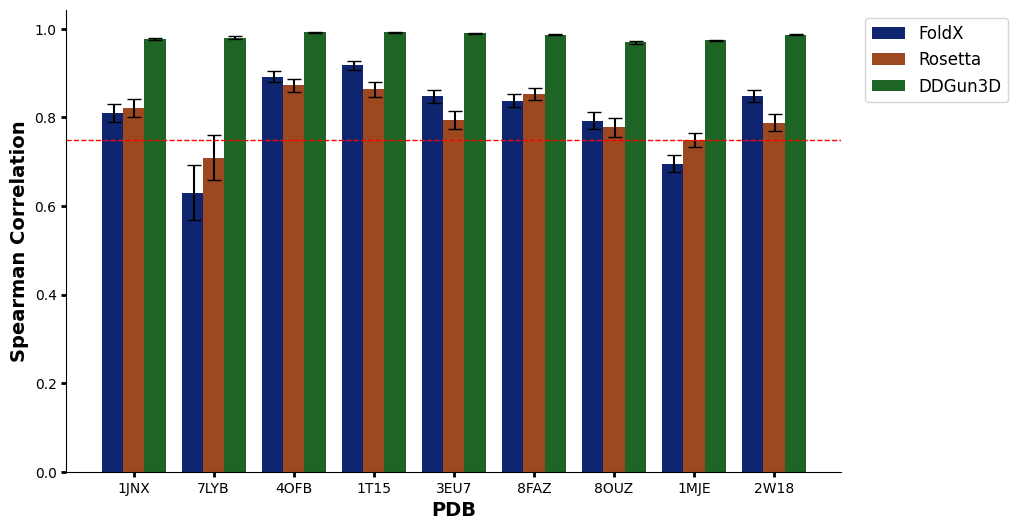

,MODEL GENE,PCC,P-Value,total,Lower Bound,Upper Bound,ERROR,PREDICTOR,GENE,PDB
0,BRCA1_1JNX,0.810163,0.000000e+00,4139,0.799429,0.820381,0.020952,FoldX,BRCA1,1JNX
1,BRCA1_7LYB,0.630423,3.617277e-159,1429,0.598120,0.660680,0.062560,FoldX,BRCA1,7LYB
2,BRCA1_4OFB,0.892211,0.000000e+00,4179,0.885855,0.898232,0.012377,FoldX,BRCA1,4OFB
3,BRCA1_1T15,0.917504,0.000000e+00,3794,0.912318,0.922395,0.010076,FoldX,BRCA1,1T15
4,PALB2_3EU7,0.847658,0.000000e+00,5045,0.839705,0.855248,0.015543,FoldX,PALB2,3EU7
5,RAD51C_8FAZ,0.837843,0.000000e+00,6279,0.830316,0.845065,0.014750,FoldX,RAD51C,8FAZ
6,RAD51C_8OUZ,0.792765,0.000000e+00,5440,0.782679,0.802434,0.019755,FoldX,RAD51C,8OUZ
7,BRCA2_1MJE,0.695808,0.000000e+00,11849,0.686402,0.704981,0.018580,FoldX,BRCA2,1MJE
8,PALB2_2W18,0.848727,0.000000e+00,5832,0.841390,0.855752,0.014362,FoldX,PALB2,2W18
9,BRCA1_1JNX,0.820784,0.000000e+00,4139,0.810587,0.830483,0.019896,Rosetta,BRCA1,1JNX


In [8]:
plt.figure(figsize=(10, 6))
g = sns.barplot(data=pcc_ddg_df, x='PDB', y='PCC', hue='PREDICTOR', palette="dark", capsize=0.1)

bar_width = 0.26
for i, subject in enumerate(pcc_ddg_df['PDB'].unique()):
    subset = pcc_ddg_df[pcc_ddg_df['PDB'] == subject]
    x_positions = [i -0.25 + (j * bar_width) for j in range(len(subset))]
    plt.errorbar(x=x_positions, y=subset['PCC'], yerr=subset['ERROR'], fmt='none',
                 ecolor='black', capsize=5)
plt.axhline(y=0.75, color='r', linestyle='--', linewidth=1)
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
plt.ylabel('Spearman Correlation', fontsize=14, fontweight='bold')
plt.xlabel('PDB', fontsize=14, fontweight='bold')
plt.tick_params(axis='x', width=2)  # Increase thickness of x ticks
plt.tick_params(axis='y', width=2)
plt.savefig('PCC_AF2_HRS_barplot_300dpi.png', dpi=300, bbox_inches='tight')

plt.show()
pcc_ddg_df

In [9]:

ddg_results_HDR_df = ddg_results_df[~ddg_results_df['HDR'].isna()]

ddg_results_HDR_pivot_df = ddg_results_HDR_df.pivot_table(index=['mutations', 'GENE_MODEL', "HDR"], columns=['predictor', 'struct_predictor'], values='ΔΔG', aggfunc='first').reset_index()
ddg_results_HDR_pivot_df.columns = ['{}_{}'.format(col[0], col[1]) if col[1] != '' else col[0] for col in ddg_results_HDR_pivot_df.columns]
ddg_results_HDR_pivot_df = ddg_results_HDR_pivot_df.dropna()
ddg_results_HDR_pivot_df = ddg_results_HDR_pivot_df.reset_index(drop=True)

pcc_HDR_ddg_df = pd.DataFrame(columns=['GENE', 'PCC', 'P-Value', 'total', 'Lower Bound', 'Upper Bound', 
                                   'ERROR', 'PREDICTOR'])

model_list = list(set(ddg_results_pivot_df.GENE_MODEL.tolist()))
for model in model_list:
    model_df = ddg_results_HDR_pivot_df[ddg_results_HDR_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['FoldX_AF2'],model_df['HDR'])
    pcc_HDR_ddg_df = pcc_HDR_ddg_df.append({'GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'AF2', 'Tool': 'FOLDX'}, ignore_index=True)
    
for model in model_list:
    model_df = ddg_results_HDR_pivot_df[ddg_results_HDR_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['Rosetta_AF2'],model_df['HDR'])
    pcc_HDR_ddg_df = pcc_HDR_ddg_df.append({'GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'AF2', 'Tool': 'Rosetta'}, ignore_index=True)
    
for model in model_list:
    model_df = ddg_results_HDR_pivot_df[ddg_results_HDR_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['DDgun3D_AF2'],model_df['HDR'])
    pcc_HDR_ddg_df = pcc_HDR_ddg_df.append({'GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'AF2', 'Tool': 'DDGun3D'}, ignore_index=True)
    
for model in model_list:
    model_df = ddg_results_HDR_pivot_df[ddg_results_HDR_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['FoldX_crystal'],model_df['HDR'])
    pcc_HDR_ddg_df = pcc_HDR_ddg_df.append({'GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'PDB', 'Tool': 'FOLDX'}, ignore_index=True)
    
for model in model_list:
    model_df = ddg_results_HDR_pivot_df[ddg_results_HDR_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['Rosetta_crystal'],model_df['HDR'])
    pcc_HDR_ddg_df = pcc_HDR_ddg_df.append({'GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'PDB', 'Tool': 'Rosetta'}, ignore_index=True)
    
for model in model_list:
    model_df = ddg_results_HDR_pivot_df[ddg_results_HDR_pivot_df['GENE_MODEL'] == model]
    r, p, lo, hi,n, err = spearmanr_ci(model_df['DDgun3D_crystal'],model_df['HDR'])
    pcc_HDR_ddg_df = pcc_HDR_ddg_df.append({'GENE': model, 
                                        'PCC': r,
                                        'P-Value': p,
                                        'total': int(n),
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'ERROR': err, 'PREDICTOR':'PDB', 'Tool': 'DDGun3D'}, ignore_index=True)
pcc_HDR_ddg_df[['GENE', "PDB"]] = pcc_HDR_ddg_df['GENE'].str.split("_", expand=True)
pcc_HDR_ddg_df[['PCC', 'total', 'Lower Bound', 'Upper Bound', 'ERROR']] = pcc_HDR_ddg_df[['PCC', 'total', 'Lower Bound', 'Upper Bound', 'ERROR']].abs()
#pcc_HDR_ddg_nopalb2_df = pcc_HDR_ddg_df[(pcc_HDR_ddg_df['GENE'] != 'PALB2_3EU7') & 
#                                       (pcc_HDR_ddg_df['GENE'] != 'PALB2_2W18')]
#pcc_HDR_ddg_nopalb2_df 
#pcc_HDR_ddg_nopalb2_df[['PCC', 'total', 'Lower Bound', 'Upper Bound', 'ERROR']] = pcc_HDR_ddg_nopalb2_df[['PCC', 'total', 'Lower Bound', 'Upper Bound', 'ERROR']].abs()
#pcc_HDR_ddg_nopalb2_df[(pcc_HDR_ddg_nopalb2_df['GENE'] =='BRCA1_4OFB') | 
#                       (pcc_HDR_ddg_nopalb2_df['GENE'] =='BRCA1_1JNX') |
#                      (pcc_HDR_ddg_nopalb2_df['GENE'] =='BRCA1_7LYB')]
#pcc_HDR_ddg_df[pcc_HDR_ddg_df['PREDICTOR'] == 'HRS']
#pcc_HDR_ddg_df[['GENE', 'PDB']] = pcc_HDR_ddg_df['GENE'].str.split('_', expand=True)
#pcc_HDR_ddg_df[pcc_HDR_ddg_df['GENE'] == 'BRCA1']
#pcc_HDR_ddg_nopalb2_df[pcc_HDR_ddg_nopalb2_df['GENE'] == 'RAD51C_8FAZ']
#pcc_HDR_ddg_nopalb2_df[['GENE', "PDB"]] = pcc_HDR_ddg_nopalb2_df['GENE'].str.split("_", expand=True)
pcc_HDR_ddg_df.columns = ['GENE', "PCC", "P-Value", "total","Lower Bound", "Upper Bound",
                          "ERROR", "MODEL", "PREDICTOR", "PDB"]
pcc_HDR_ddg_df['ERROR'] = pcc_HDR_ddg_df['ERROR']/2

In [10]:

pcc_HDR_ddg_df[(pcc_HDR_ddg_df['MODEL'] == 'AF2') & 
               (pcc_HDR_ddg_df['GENE'] == 'BRCA2') &
              (pcc_HDR_ddg_df['PDB'] == '1MJE')]
pcc_HDR_ddg_df.to_csv("scc_HDR_structure_results.csv", index=None)

<Figure size 800x600 with 0 Axes>

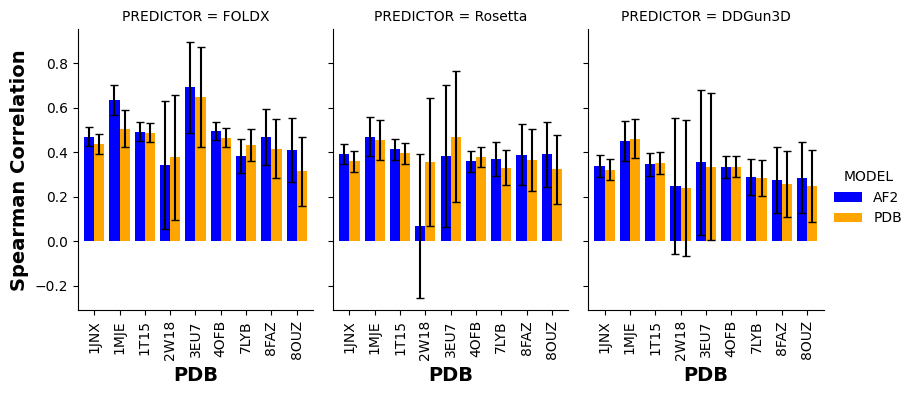

In [11]:

def errplot(x, y, yerr, hue, **kwargs):
    data = kwargs.pop('data')
    p = data.pivot_table(index=x, columns=hue, values=y, aggfunc='mean')
    err = data.pivot_table(index=x, columns=hue, values=yerr, aggfunc='mean')
    p.plot(kind='bar', yerr=err, ax=plt.gca(), **kwargs, capsize=3)
plt.figure(figsize=(8, 6))
g = sns.FacetGrid(pcc_HDR_ddg_df, col="PREDICTOR", height=4, aspect=.7)
g.map_dataframe(errplot, "PDB", "PCC", 'ERROR', "MODEL",  color=['blue', 'orange'], width=0.8)
g.set_ylabels('Spearman Correlation', fontsize=14, fontweight='bold')
g.set_xlabels('PDB', fontsize=14, fontweight='bold')
g.add_legend(title="MODEL")
plt.savefig('correlation_mave_results.png', dpi=300)
plt.show()